In [1]:
%matplotlib inline

In [2]:
from collections import Counter, defaultdict
import json
import os
import pickle
import random

from joblib import Parallel, delayed
import networkx as nx
from networkx.algorithms.community.quality import modularity as nx_modularity
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

In [3]:
def create_krondecker(partition):
    n = len(partition)
    kron_mask = np.tile(partition, n) == np.repeat(partition, n)
    return np.reshape(kron_mask, (n, n))

def modularity2(AIJ, partition):
    n = len(AIJ)
    m = np.sum(AIJ)  # no of edges

    k = np.sum(AIJ, axis=1)
    expectation = np.reshape(np.tile(k, n) * np.repeat(k, n), (n, n)) / m
    kron = create_krondecker(partition)

    # Q = (1 / 2m) * SUM(AIJ - (ki.kj / 2m)) ∂(ci, cj)
    return (1.0 / m) * np.sum(kron * (AIJ - expectation))

In [4]:
def np2nx(A: np.ndarray, partition: np.ndarray):
    G = nx.from_numpy_matrix(A)
    nx.set_node_attributes(G, dict(enumerate(partition)), 'community')
    return G

def partition2communities(partition):
    result = defaultdict(list)
    for idx, class_ in enumerate(partition):
        result[class_].append(idx)
    return list(result.values())

def estimate_mu(graph, partition):
    n_out_edges = 0
    n_nodes = graph.size()
    for n1, n2 in graph.edges():  # links:
        if partition[n1] != partition[n2]:
            n_out_edges += 1
    return n_out_edges / n_nodes

def power_law(values, maxval=200):
    tau = powerlaw.Fit(values, verbose=False).alpha
    if tau > maxval or np.isnan(tau):
        tau = maxval
    return tau

def power_law_my(values, maxval=200):
    values_count = sorted(Counter(values).items(), key=lambda x: x[0], reverse=True)
    deg, cnt = zip(*values_count)
    cnt = np.cumsum(cnt)
    if len(cnt) < 2:
        return maxval
    params, _ = curve_fit(lambda x, a, b: x * a + b, np.log(deg), np.log(cnt))
    tau = -1 * params[0] + 1
    if tau > maxval or np.isnan(tau):
        return maxval
    return tau

def redetect_params(data):
    A, partition = data['A'], data['y_true']
    G = np2nx(A, partition)
    
    if not nx.is_connected(G):
        return {'is_connected': False}
    
    # Graph-based parameters
    n = G.number_of_nodes()
    avg_degree = 2 * G.number_of_edges() / n
    node_degrees = [d for n, d in G.degree()]
    min_degree = np.min(node_degrees)
    max_degree = np.max(node_degrees)
    tau1 = power_law(node_degrees, 1000000)
    tau1_mypowerlaw = power_law_my(node_degrees, 1000000)
    diameter = nx.diameter(G)
    avg_sp = nx.average_shortest_path_length(G)
    assortativity = nx.degree_assortativity_coefficient(G)
    avg_clustering = nx.average_clustering(G)

    # Community-based parameters
    k = len(set(partition))
    mu = min(max(estimate_mu(G, partition), 0.), 1.)
    community_sizes = list(Counter(partition).values())
    min_community = np.min(community_sizes)
    avg_community = np.mean(community_sizes)
    max_community = np.max(community_sizes)
    tau2 = power_law(community_sizes, 1000000)
    tau2_mypowerlaw = power_law_my(community_sizes, 1000000)
    modularity = nx_modularity(G, partition2communities(partition))
    
    return {
        'is_connected': True,
        'n': n,
        'k': k,
        'min_degree': min_degree,
        'avg_degree': avg_degree,
        'max_degree': max_degree,
        'tau1': tau1,
        'tau1|mypowerlaw': tau1_mypowerlaw,
        'mu': mu,
        'min_community': min_community,
        'avg_community': avg_community,
        'max_community': max_community,
        'tau2': tau2,
        'tau2|mypowerlaw': tau2_mypowerlaw,
        'modularity': modularity,
        'diameter': diameter,
        'avg_sp': avg_sp,
        'assortativity': assortativity,
        'avg_clustering': avg_clustering
    }


feature_inv = lambda x, power: (1 - (1 / x**power))

def add_extra_params(params, model_params, measure_best_results):
    params['maxari'] = np.max(list(measure_best_results.values()))
    params['sp_ari'] = model_params['est_SP_ARI']
    params['ct_ari'] = model_params['est_CT_ARI']
        
    params['n|log'] = np.log(params['n'])
    params['k|log'] = np.log(params['k'])
    params['k|inv'] = feature_inv(params['k'], 1)

    params['tau1|inv'] = feature_inv(params['tau1'], 1)
    params['tau2|inv'] = feature_inv(params['tau2'], 1)
    params['tau1|sqrtinv'] = feature_inv(params['tau1'], 0.5)
    params['tau2|sqrtinv'] = feature_inv(params['tau2'], 0.5)
    
    params['tau1|mypowerlaw|inv'] = feature_inv(params['tau1|mypowerlaw'], 1)
    params['tau2|mypowerlaw|inv'] = feature_inv(params['tau2|mypowerlaw'], 1)
    params['tau1|mypowerlaw|sqrtinv'] = feature_inv(params['tau1|mypowerlaw'], 0.5)
    params['tau2|mypowerlaw|sqrtinv'] = feature_inv(params['tau2|mypowerlaw'], 0.5)
    
    params['min_degree|log'] = np.log(params['min_degree'])
    params['avg_degree|log'] = np.log(params['avg_degree'])
    params['max_degree|log'] = np.log(params['max_degree'])
    params['min_density'] = params['min_degree'] / (params['n'] - 1)
    params['avg_density'] = params['avg_degree'] / (params['n'] - 1)
    params['max_density'] = params['max_degree'] / (params['n'] - 1)
    
    params['min_community|log'] = np.log(params['min_community'])
    params['avg_community|log'] = np.log(params['avg_community'])
    params['max_community|log'] = np.log(params['max_community'])
    params['min_community/n'] = params['min_community'] / params['n']
    params['avg_community/n'] = params['avg_community'] / params['n']
    params['max_community/n'] = params['max_community'] / params['n']
    
    params['mu/avg_density'] = params['mu'] / params['avg_density']
    params['mu/avg_density|log'] = np.log(params['mu/avg_density'])
    
    return params

In [5]:
def plot_iconostas(dataset):
    def plot_hist(axi, feature_name):
        data = np.array([item['estimated_params'][feature_name] if item['estimated_params'][feature_name] is not None else np.nan for name, item in dataset])
        axi.hist(data[~np.isnan(data)], bins=50)
        axi.set_title(feature_name)

    fig, ax = plt.subplots(7, 6, figsize=(24, 28))

    plot_hist(ax[0][0], 'n')

    plot_hist(ax[0][3], 'k')
    plot_hist(ax[0][4], 'k|log')
    plot_hist(ax[0][5], 'k|inv')

    plot_hist(ax[1][0], 'tau1')
    plot_hist(ax[1][1], 'tau1|inv')
    plot_hist(ax[1][2], 'tau1|sqrtinv')
    plot_hist(ax[1][3], 'tau2')
    plot_hist(ax[1][4], 'tau2|inv')
    plot_hist(ax[1][5], 'tau2|sqrtinv')

    plot_hist(ax[2][0], 'min_degree')
    plot_hist(ax[2][1], 'avg_degree')
    plot_hist(ax[2][2], 'max_degree')
    plot_hist(ax[2][3], 'min_community')
    plot_hist(ax[2][4], 'avg_community')
    plot_hist(ax[2][5], 'max_community')

    plot_hist(ax[3][0], 'min_degree|log')
    plot_hist(ax[3][1], 'avg_degree|log')
    plot_hist(ax[3][2], 'max_degree|log')
    plot_hist(ax[3][3], 'min_community|log')
    plot_hist(ax[3][4], 'avg_community|log')
    plot_hist(ax[3][5], 'max_community|log')

    plot_hist(ax[4][0], 'min_density')
    plot_hist(ax[4][1], 'avg_density')
    plot_hist(ax[4][2], 'max_density')
    plot_hist(ax[4][3], 'min_community/n')
    plot_hist(ax[4][4], 'avg_community/n')
    plot_hist(ax[4][5], 'max_community/n')

    plot_hist(ax[5][0], 'mu')
    plot_hist(ax[5][1], 'mu/avg_density')
    plot_hist(ax[5][2], 'mu/avg_density|log')
    plot_hist(ax[5][3], 'modularity')
    plot_hist(ax[5][4], 'maxari')

    plot_hist(ax[6][0], 'sp_ari')
    plot_hist(ax[6][1], 'ct_ari')
    plot_hist(ax[6][2], 'diameter')
    plot_hist(ax[6][3], 'avg_sp')
    plot_hist(ax[6][4], 'assortativity')
    plot_hist(ax[6][5], 'avg_clustering')

    plt.tight_layout()

In [6]:
def plot_iconostas_small(dataset):
    def plot_hist(axi, feature_name):
        data = np.array([item['estimated_params'][feature_name] if item['estimated_params'][feature_name] is not None else np.nan for name, item in dataset])
        axi.hist(data[~np.isnan(data)], bins=50)
        axi.set_title(feature_name)

    fig, ax = plt.subplots(6, 2, figsize=(6, 12))
    plot_hist(ax[0][0], 'n')
    plot_hist(ax[0][1], 'tau1|sqrtinv')
    plot_hist(ax[1][0], 'min_degree|log')
    plot_hist(ax[1][1], 'min_density')
    plot_hist(ax[2][0], 'avg_degree|log')
    plot_hist(ax[2][1], 'avg_density')
    plot_hist(ax[3][0], 'max_degree|log')
    plot_hist(ax[3][1], 'max_density')
    plot_hist(ax[4][0], 'diameter')
    plot_hist(ax[4][1], 'avg_sp')
    plot_hist(ax[5][0], 'assortativity')
    plot_hist(ax[5][1], 'avg_clustering')
    plt.tight_layout()
    plt.plot()

    fig, ax = plt.subplots(6, 2, figsize=(6, 12))
    plot_hist(ax[0][0], 'k|log')
    plot_hist(ax[0][1], 'tau2|sqrtinv')
    plot_hist(ax[1][0], 'min_community|log')
    plot_hist(ax[1][1], 'min_community/n')
    plot_hist(ax[2][0], 'avg_community|log')
    plot_hist(ax[2][1], 'avg_community/n')
    plot_hist(ax[3][0], 'max_community|log')
    plot_hist(ax[3][1], 'max_community/n')
    plot_hist(ax[4][0], 'mu')
    plot_hist(ax[4][1], 'mu/avg_density|log')
    plot_hist(ax[5][0], 'modularity')
#     plot_hist(ax[5][1], 'maxari')
    fig.delaxes(ax[5][1])

    plt.tight_layout()
    plt.plot()

In [7]:
def plot_iconostas_lfr(dataset):
    def plot_hist(axi, feature_name):
        data = np.array([item['estimated_params'][feature_name] if item['estimated_params'][feature_name] is not None else np.nan for name, item in dataset])
        axi.hist(data[~np.isnan(data)], bins=50)
        axi.set_title(feature_name)

    fig, ax = plt.subplots(2, 3, figsize=(10, 5))

    plot_hist(ax[0][0], 'n')
    ax[0][0].set_xlim(0, 1500)
    ax[0][1].set_title(r'$n$')
    
    plot_hist(ax[0][1], 'tau1|sqrtinv')
    ax[0][1].set_xlim(None, 1)
    ax[0][1].set_title(r'$\tau_1$')
    ax[0][1].set_xticks([feature_inv(2, 0.5), feature_inv(10, 0.5), feature_inv(100, 0.5)])
    ax[0][1].set_xticklabels([2, 10, 100])
    
    plot_hist(ax[0][2], 'tau2|sqrtinv')
    ax[0][2].set_xlim(None, 1)
    ax[0][2].set_title(r'$\tau_2$')
    ax[0][2].set_xticks([feature_inv(2, 0.5), feature_inv(10, 0.5), feature_inv(100, 0.5)])
    ax[0][2].set_xticklabels([2, 10, 100])
    
    plot_hist(ax[1][0], 'mu')
    ax[1][0].set_xlim(0, 1)
    ax[1][0].set_title(r'$\mu$')
    
#     plot_hist(ax[1][0], 'avg_density')
#     ax[1][0].set_xlim(0, None)
#     ax[1][0].set_title('density')
    
    plot_hist(ax[1][1], 'avg_degree|log')
#     ax[1][1].set_xlim(0, 0.9)
    ax[1][1].set_title('avg degree')
    ax[1][1].set_xticks([np.log(1), np.log(10), np.log(100), np.log(1000)])
    ax[1][1].set_xticklabels([1, 10, 100, 1000])
    
    plot_hist(ax[1][2], 'modularity')
    ax[1][2].set_xlim(-0.5, 0.9)
    
#     plot_hist(ax[1][3], 'maxari')
#     ax[1][3].set_xlim(0, 1)
#     ax[1][3].set_title('ARI of winning measure')

#     items = [prepare_info(x[1]['estimated_params']) for x in dataset]
#     distances = euclidean_distances(items, items)
#     np.fill_diagonal(distances, 9999)
#     min_distances = np.min(distances, axis=0)

#     ax[1][2].hist(min_distances, bins=50);
#     ax[1][2].set_xlim(0, None)
#     ax[1][2].set_title('min distance in 5d space')

    plt.tight_layout()
    
    plt.savefig('pics/features_distribution.pdf')

# Prepare simple results

In [8]:
from_folder = '/data/phd/pygkernels/montecarlo_lfr'
to_folder = '/data/phd/pygkernels/montecarlo_lfr_simple'

# step 1: form list of non-exist simple files
raw_files = [fn[:-4] for fn in os.listdir(from_folder) if fn.endswith('.pkl')]
simple_files = [fn[:-5] for fn in os.listdir(to_folder) if fn.endswith('.json')]
to_perform = [name for name in raw_files]# if name not in simple_files]
to_perform = sorted(to_perform, key=lambda x: float(x.split('_')[0]))
print(f'To perform: {len(to_perform)} files')

# step 2: check/update modularity for non-simplified files and prepare simple content
def perform_one(name):
    print(name)
    with open(f'{from_folder}/{name}.pkl', 'rb') as f:
        data = pickle.load(f)
    need_to_save = False
    A = data['A']
    gt_modularity = modularity2(A, data['y_true'])

    item = {}
    for kernel_name, kernel_results in data['results'].items():
        kernel_param_best_ari = {}
        kernel_best_ari = -1
        for parameter, parameter_results in kernel_results.items():
            if len(parameter_results) > 0:
                if 'new_modularity2' not in parameter_results[0]:  # add new_modularity if not exist
                    for init_idx, init in enumerate(parameter_results):
                        partition = init['labels']
                        init['new_modularity2'] = modularity2(A, partition)
                    need_to_save = True
                if gt_modularity >= 0:  # associative case
                    param_best_ari = sorted(parameter_results, key=lambda x: -x['new_modularity2'])[0]['score_ari']
                else:  # dissociative case
                    param_best_ari = sorted(parameter_results, key=lambda x: x['new_modularity2'])[0]['score_ari']
                need_to_save = True
                
#                 if 'nx_modularity' not in parameter_results[0]:  # add new_modularity if not exist
#                     for init_idx, init in enumerate(parameter_results):
#                         partition = init['labels']
#                         init['nx_modularity'] = nx_modularity(np2nx(A, partition), partition2communities(partition))
#                     need_to_save = True
#                 param_best_ari = sorted(parameter_results, key=lambda x: -x['nx_modularity'])[0]['score_ari']
                
                kernel_param_best_ari[parameter] = param_best_ari
                kernel_best_ari = max(kernel_best_ari, param_best_ari)
                
        item[kernel_name] = kernel_best_ari
        
        if kernel_name == 'SP-CT':
            data['info']['est_SP_ARI'] = kernel_param_best_ari[1.0] if 1.0 in kernel_param_best_ari else None
            data['info']['est_CT_ARI'] = kernel_param_best_ari[0.0] if 0.0 in kernel_param_best_ari else None
    
    if need_to_save:
        with open(f'{from_folder}/{name}.pkl', 'wb') as f:
            pickle.dump(data, f)
            
    estimated_params = redetect_params(data)
    if estimated_params['is_connected']:
        estimated_params = add_extra_params(estimated_params, data['info'], item)
        result = {
            'measure_best_results': item,
            'model_params': {k: float(v) if str(v).isdigit() else v for k, v in data['info'].items()},
            'estimated_params': {k: float(v) if str(v).isdigit() else v for k, v in estimated_params.items()}
        }
        try:
            with open(f'{to_folder}/{name}.json', 'w') as f:
                json.dump(result, f, indent=4)
        except:
            print('ERROR IN', name)
    
Parallel(n_jobs=12)(delayed(perform_one)(name) for name in tqdm(to_perform));

To perform: 7739 files


## all_dataset.json 

In [51]:
dataset = []
for fn in tqdm([x for x in os.listdir(to_folder) if x.endswith('.json')]):
    try:
        with open(f'{to_folder}/{fn}', 'r') as f:
            data = json.load(f)
        dataset.append((fn, data))
    except:
        print('ERROR IN', fn)
print('Total points in dataset:', len(dataset))

ERROR IN 1143_19.02_1.17_0.61_14.03_2.00.json
ERROR IN 1236_3.26_1.11_0.75_12.91_51.00.json
ERROR IN 1407_2.50_3.79_0.96_13.35_29.00.json
ERROR IN 1449_6.12_1.26_0.11_13.04_12.00.json

Total points in dataset: 7550


In [52]:
with open('all_dataset.json', 'w') as f:
    json.dump([{k: v for k, v in item['model_params'].items()} for name, item in dataset], f)

# Feature stats

In [11]:
for idx, feature_name in enumerate(dataset[0][1]['estimated_params'].keys()):
    print(idx, feature_name)

0 is_connected
1 n
2 k
3 min_degree
4 avg_degree
5 max_degree
6 tau1
7 tau1|mypowerlaw
8 mu
9 min_community
10 avg_community
11 max_community
12 tau2
13 tau2|mypowerlaw
14 modularity
15 diameter
16 avg_sp
17 assortativity
18 avg_clustering
19 maxari
20 sp_ari
21 ct_ari
22 n|log
23 k|log
24 k|inv
25 tau1|inv
26 tau2|inv
27 tau1|sqrtinv
28 tau2|sqrtinv
29 tau1|mypowerlaw|inv
30 tau2|mypowerlaw|inv
31 tau1|mypowerlaw|sqrtinv
32 tau2|mypowerlaw|sqrtinv
33 min_degree|log
34 avg_degree|log
35 max_degree|log
36 min_density
37 avg_density
38 max_density
39 min_community|log
40 avg_community|log
41 max_community|log
42 min_community/n
43 avg_community/n
44 max_community/n
45 mu/avg_density
46 mu/avg_density|log


## Distances hist

In [12]:
def shuffle(X):
    return sorted(X, key=lambda x: random.random())

def euclidean_distances(X, Y):
    X, Y = np.array(X), np.array(Y)
    result = np.sqrt(np.sum(np.power(X[:, None] - Y[None, :], 2), axis=2))
    return result

def prepare_info(info):
    n = info['n'] / 1500
    tau1 = 1 - (1 / info['tau1'])
    tau2 = 1 - (1 / info['tau2'])
    mu = info['mu']
    density = info['avg_degree'] / (info['n'] - 1)
    return [n, tau1, tau2, mu, density]

def normalized_5d(dataset):
    items = [prepare_info(x[1]['estimated_params']) for x in dataset]

    feature_min = {fn: np.min([item[fn] for item in items]) for fn in range(5)}
    feature_max = {fn: np.max([item[fn] for item in items]) for fn in range(5)}
    feature_width = {fn: feature_max[fn] - feature_min[fn] for fn in range(5)}
    feature_normalize = lambda x, fn: (x - feature_min[fn]) / feature_width[fn]

    for item_idx in range(len(items)):
        for feature_idx in range(5):
            items[item_idx][feature_idx] = feature_normalize(items[item_idx][feature_idx], feature_idx)
        
    return items

## Remove close points

In [53]:
len(dataset)

7550

In [54]:
dataset = [(name, item) for name, item in dataset if item['estimated_params']['tau2'] != 1000000]
len(dataset)

7396

In [55]:
dataset = shuffle(dataset)
items = normalized_5d(dataset)

groupby005 = {}
for (name, item), coords in zip(dataset, items):
    coords = tuple([(x if x != 1 else x - 0.00001)*100//5 for x in coords])
    groupby005[coords] = (name, item)

In [56]:
# dataset2 = list(groupby005.values())
# len(dataset2)

dataset2 = dataset.copy()

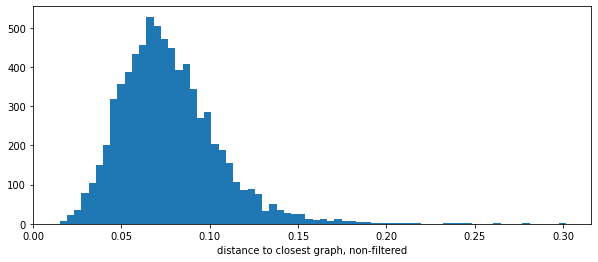

In [57]:
items = normalized_5d(dataset)
distances = euclidean_distances(items, items)
np.fill_diagonal(distances, 9999)
min_distances = np.min(distances, axis=0)
plt.subplots(1, figsize=(10, 4))
plt.hist(min_distances, bins=70)
plt.xlim(0, None)
plt.xlabel('distance to closest graph, non-filtered');

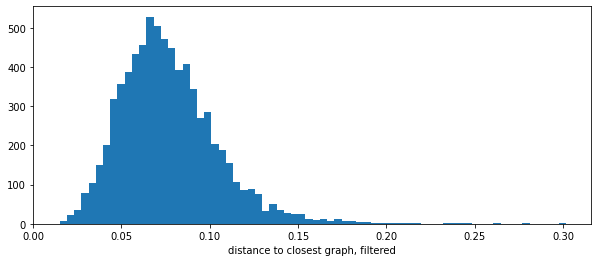

In [58]:
items = normalized_5d(dataset2)
distances = euclidean_distances(items, items)
np.fill_diagonal(distances, 9999)
min_distances = np.min(distances, axis=0)
plt.subplots(1, figsize=(10, 4))
plt.hist(min_distances, bins=70)
plt.xlim(0, None)
plt.xlabel('distance to closest graph, filtered');

In [59]:
np.max(min_distances)

0.3014924150283347

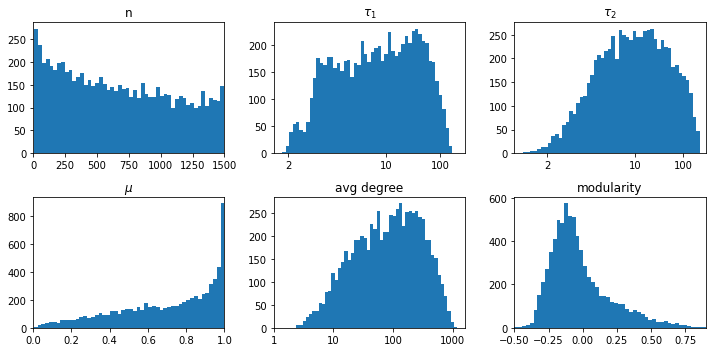

In [60]:
plot_iconostas_lfr(dataset)

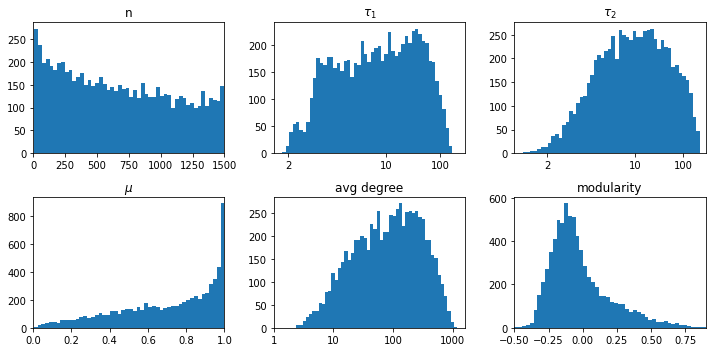

In [61]:
plot_iconostas_lfr(dataset2)

In [62]:
len([k for k, v in dataset2 if 2 <= v['model_params']['tau1'] <= 3]) / len(dataset2)

0.14656571119524067

In [63]:
with open('filtered_dataset.json', 'w') as f:
    json.dump([x[1] for x in dataset2], f)

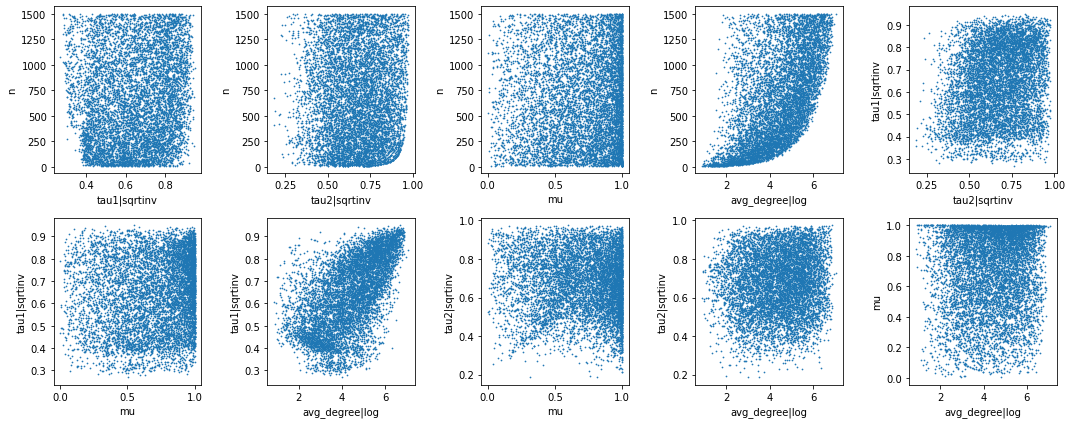

In [64]:
set_feature = lambda feature_name: [x['estimated_params'][feature_name] for _, x in dataset]

def draw(ax, fnameX, fnameY):
    ax.scatter(set_feature(fnameX), set_feature(fnameY), s=0.5)
    ax.set_xlabel(fnameX)
    ax.set_ylabel(fnameY)
    

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
draw(ax[0][0], 'tau1|sqrtinv', 'n')
draw(ax[0][1], 'tau2|sqrtinv', 'n')
draw(ax[0][2], 'mu', 'n')
draw(ax[0][3], 'avg_degree|log', 'n')
draw(ax[0][4], 'tau2|sqrtinv', 'tau1|sqrtinv')

draw(ax[1][0], 'mu', 'tau1|sqrtinv')
draw(ax[1][1], 'avg_degree|log', 'tau1|sqrtinv')
draw(ax[1][2], 'mu', 'tau2|sqrtinv')
draw(ax[1][3], 'avg_degree|log', 'tau2|sqrtinv')
draw(ax[1][4], 'avg_degree|log', 'mu')

plt.tight_layout()

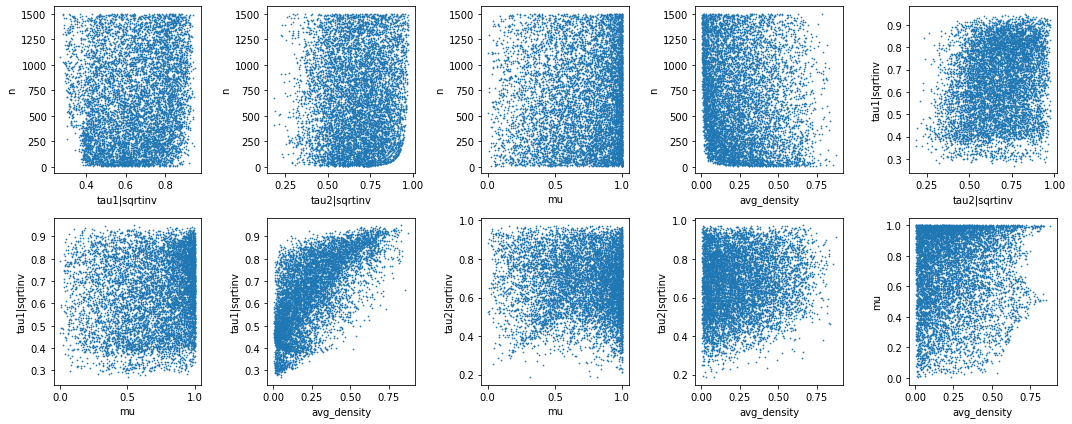

In [65]:
set_feature = lambda feature_name: [x['estimated_params'][feature_name] for _, x in dataset2]

def draw(ax, fnameX, fnameY):
    ax.scatter(set_feature(fnameX), set_feature(fnameY), s=0.5)
    ax.set_xlabel(fnameX)
    ax.set_ylabel(fnameY)
    

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
draw(ax[0][0], 'tau1|sqrtinv', 'n')
draw(ax[0][1], 'tau2|sqrtinv', 'n')
draw(ax[0][2], 'mu', 'n')
draw(ax[0][3], 'avg_density', 'n')
draw(ax[0][4], 'tau2|sqrtinv', 'tau1|sqrtinv')

draw(ax[1][0], 'mu', 'tau1|sqrtinv')
draw(ax[1][1], 'avg_density', 'tau1|sqrtinv')
draw(ax[1][2], 'mu', 'tau2|sqrtinv')
draw(ax[1][3], 'avg_density', 'tau2|sqrtinv')
draw(ax[1][4], 'avg_density', 'mu')

plt.tight_layout()